In [101]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [102]:
df = pd.read_csv('cumulative.csv', index_col=1)

In [103]:
df.head()

,rowid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepid,,,,,,,,,,,,,,,,,,,,,
10797460,1,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
10797460,2,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
10811496,3,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
10848459,4,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
10854555,5,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


All rows accounted for, none listed that are labeled as "NOT DISPOSITIONED"

In [104]:
print(df['koi_disposition'].value_counts().sum())
df['koi_disposition'].value_counts()

9564


koi_disposition
FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: count, dtype: int64

Make a list of columns that don't have "err1" or "err2" in its name- we don't want to use the error columns.

In [105]:
features = []
for col in df.columns:
    if ('err1' not in col) and ('err2' not in col):
        features.append(col)

In [106]:
# list of columns that need to be dropped from the training data
unused_features = [
    'koi_disposition',
    'koi_pdisposition',
    'koi_score',
    'rowid',
    'kepoi_name',
    'kepler_name',
    'koi_tce_delivname',
    'koi_tce_plnt_num'
    ]

In [107]:
y = df['koi_disposition'] # target variable
x = df[features].drop(unused_features, axis = 1) # can't use koi_score and koi_pdisposition: leakage

In [108]:
x.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
kepid,,,,,,,,,,,,,,,,,,,
10797460,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
10797460,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
10811496,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129,15.436
10848459,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597
10854555,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509


Looks like only the `fpflag` columns are categorical. Let's set the names of those aside.

In [109]:
discrete = []
for col in x.columns:
    if 'fpflag' in col:
        discrete.append(col)

All the rest of the columns have continuous values.

In [110]:
continuous = list(x.columns.difference(discrete)) # get a list of all of the columns of x that are not in the `discrete` list

Count the number of NaNs in each column

In [111]:
pd.isna(x).sum()

koi_fpflag_nt      0
koi_fpflag_ss      0
koi_fpflag_co      0
koi_fpflag_ec      0
koi_period         0
koi_time0bk        0
koi_impact       363
koi_duration       0
koi_depth        363
koi_prad         363
koi_teq          363
koi_insol        321
koi_model_snr    363
koi_steff        363
koi_slogg        363
koi_srad         363
ra                 0
dec                0
koi_kepmag         1
dtype: int64

Will need to impute NaN values in these rows (or drop the columns)

In [112]:
len(x)

9564

In [113]:
len(x.dropna())

9200

Dropping NaNs would reduce our sample by ~350, so I'll impute missing values instead

Convert pd Series of labels to a numpy array of true/false

In [114]:
y = y.to_numpy() # convert from a Series to an array
y = (y == 'CONFIRMED') # make each element True if the current value is CONFIRMED, and False otherwise

In [115]:
y

array([ True,  True, False, ..., False, False, False])

Let's split our data into testing and training sets:

In [116]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 999) # take 20% of the dataset as training data and set a seed for the random split

Prepare a pipline for continuous values to impute missing values and scale all values.

In [117]:
continuous_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')), # fill NaNs with median value
    ('z_scale', StandardScaler()) # replace all values with the z score (amount of standard deviations from the mean)
    
])

Now that we have a pipeline for the continuous variables, we can make a pipeline to apply to the whole set. I don't think we need to manipulate the discrete variables at all, so all this does is call the continuous pipeline for only the continuous variables with a passthrough pipeline that leaves the discrete values untouched. 

In [118]:
complete_pipeline = ColumnTransformer([
    ('discrete', 'passthrough', discrete),
    ('continuous', continuous_pipeline, continuous)
])

In [119]:
x_train_transform = complete_pipeline.fit_transform(x_train)

Here's the transformed training data:

In [120]:
pd.DataFrame(x_train_transform).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,0.0,0.817056,-0.274843,0.081080,0.032798,-0.048104,-0.362871,-0.224290,-0.038061,-0.034405,-0.357364,-0.036583,0.102757,-0.367832,-0.279536,-0.694113
1,1.0,0.0,0.0,0.0,1.695261,-0.279801,-0.444954,-0.198761,-0.048522,-1.326865,-0.314639,0.043354,-0.035351,-0.131082,-0.077782,1.049275,-0.751722,0.460878,1.139732
2,0.0,1.0,0.0,0.0,0.425560,1.577316,-0.275798,0.045519,0.015215,-1.885881,1.932538,-0.052365,0.005753,-0.590645,0.033367,1.917770,1.794319,-0.490258,-1.264504
3,1.0,0.0,1.0,0.0,-0.505084,-0.280782,-0.751314,-0.200319,-0.022049,0.511450,-0.300759,-0.052898,-0.035678,0.510441,-0.143175,0.279270,1.192231,-0.501166,-1.172003
4,0.0,0.0,0.0,0.0,0.195395,-0.280310,-0.172290,0.011172,-0.047784,-1.688454,-0.277626,-0.037903,-0.035149,-0.639634,0.010401,0.556830,-0.242981,-0.217767,-0.140799


Let's transform the testing set too (without peeking)
- Here I'm calling `transform()` instead of `fit_transform()`- we want to make sure that the testing set gets the exact same transformations as the training set (using the training median, mean, and standard deviation for imputing/scaling)

In [121]:
x_test_transform = complete_pipeline.transform(x_test)

Now we can finally get to training a model!

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.model_selection import cross_val_predict

In [123]:
sgd = SGDClassifier()
sgd.fit(x_train_transform, y_train)

SGDClassifier()

Hovering at around 80% accuracy. We can probably do better with some hyperparameter tuning.

In [124]:
cross_val_score(sgd, x_train_transform, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1)

array([0.79294579, 0.8248366 , 0.80196078, 0.82352941, 0.80130719])

On the whole training set:

In [125]:
preds = sgd.predict(x_train_transform)

In [126]:
metrics.accuracy_score(y_train, preds)

0.8013331590641746

Preparing a range of parameters to test

In [127]:
suggested_iter = np.ceil(10**6 / len(y_train)) # range of iterations suggested on the sklearn docs

In [128]:
params = [{
    'alpha': 10.0**-np.arange(1,7), # suggested range on the sklearn docs: arange() creates an array of floats in the specified range
    'max_iter': range(ceil(suggested_iter*.80), ceil(suggested_iter*1.20)) # range from 80% to 120% of the suggested amount
}]

In [129]:
grid = GridSearchCV(sgd, params, cv = 5, scoring = 'accuracy', return_train_score= True)

In [ ]:
best_fit = grid.fit(x_train_transform, y_train)

c:\Users\juven\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\juven\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\juven\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\juven\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Of all the listed parameters, this was found to be the best combination

In [131]:
best_fit.best_params_

{'alpha': 0.0001, 'max_iter': 157}

Get an array of predictions using the best parameters

In [132]:
preds = best_fit.predict(x_train_transform)

Get scores for the training set for use with the ROC curve. Could also use `cross_val_predict` to use the best fold to make predictions, but just gonna stick with the tuned model for now.

In [133]:
scores = best_fit.decision_function(x_train_transform)

79.8% accuracy, a negligible difference.

In [134]:
metrics.accuracy_score(y_train, preds)

0.8100901842896353

In [135]:
cross_val_score(best_fit, x_train_transform, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1)

array([0.79686479, 0.82418301, 0.80065359, 0.82026144, 0.8       ])

Pretty much the same results. 

In [136]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [137]:
def cm(true, predicted): # taken from lecture 4
    cm = metrics.confusion_matrix(true, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

    cm_display.plot()

In [138]:
def roc(truth, scores): # taken from lecture 4
    precisions, recalls, thresholds = metrics.precision_recall_curve(truth, scores)

    recall_90_precision = recalls[np.argmax(precisions >= 0.90)-1] # adjusted this to -1, think it was using the wrong index before
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores)

    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
        plt.axis([0, 1, 0, 1])                                    # Not shown in the book
        plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
        plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
        plt.grid(True)                                            # Not shown

    plt.figure(figsize=(8, 6))                                    # Not shown
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
    plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
    #save_fig("roc_curve_plot")                                    # Not shown
    plt.show()

In [139]:
# print various evaluation metrics for a model, given a set of labeled values, a set of predictions, and a set of scores (logits or probabilities)
def evaluation_metrics(truth : np.array, predictions : np.array , scores = np.empty(0)): 
    cm(truth, predictions)
    if len(scores) != 0:
        roc(truth, scores)
        print(f'AUC: {metrics.roc_auc_score(truth, scores)}')

    print(f'Accuracy: {metrics.accuracy_score(truth, predictions)}')
    print(f'Precision: {metrics.precision_score(truth, predictions)}')
    print(f'Recall: {metrics.recall_score(truth, predictions)}')
    print(f'F1: {metrics.f1_score(truth, predictions)}')
        


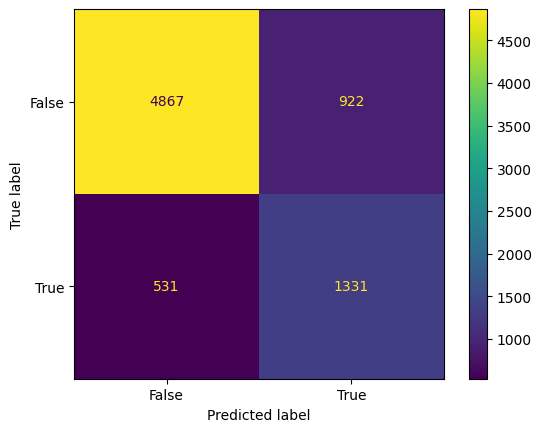

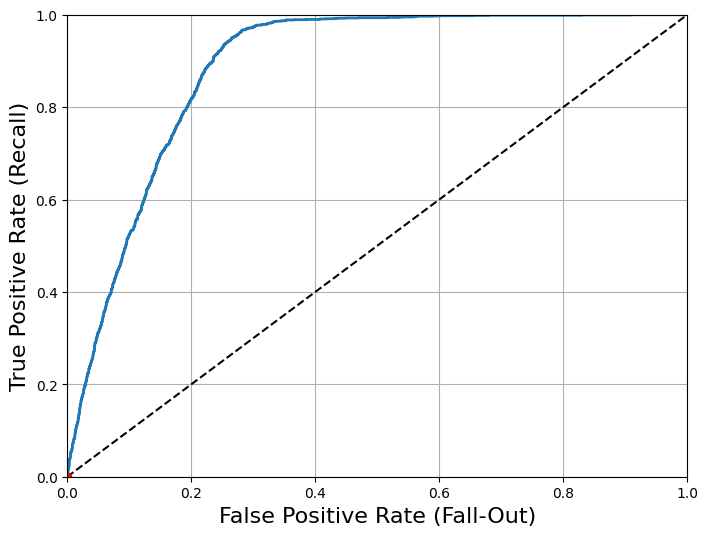

AUC: 0.8860706414012725
Accuracy: 0.8100901842896353
Precision: 0.5907678650687972
Recall: 0.7148227712137487
F1: 0.6469015795868773


In [140]:
evaluation_metrics(y_train, preds, scores)

This is pretty poor performance overall. Let's see if we can make a better model before we try it on the test data.

In [141]:
rf = RandomForestClassifier()

In [142]:
rf_params = {"n_estimators": (10, 20, 50, 100, 200), "max_depth": range(3, 10), "max_features": ("sqrt", "log2")}

In [143]:
trees = GridSearchCV(rf, rf_params, scoring = 'accuracy', n_jobs = -1, refit = True)

In [144]:
trees.fit(x_train_transform, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 10),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': (10, 20, 50, 100, 200)},
             scoring='accuracy')

In [145]:
trees.best_params_

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 100}

In [146]:
rf_preds = trees.predict(x_train_transform)
rf_scores = trees.predict_proba(x_train_transform)[:, 1] # For each observation, get the probability that the observation belongs to each class, and take the second column (probability that it belongs to the positive class)

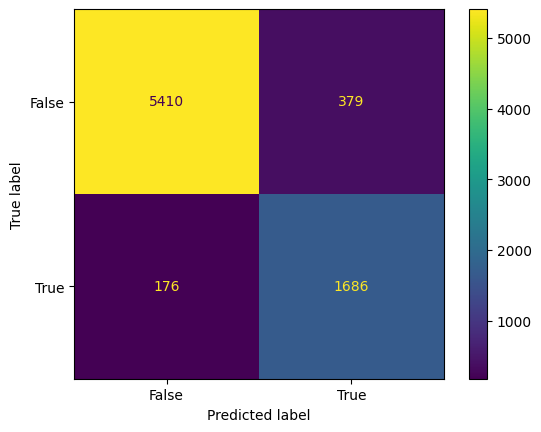

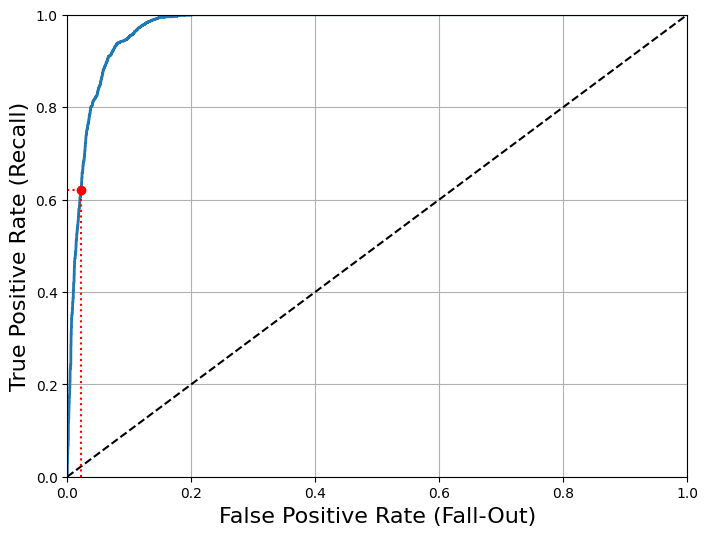

AUC: 0.9744694324711911
Accuracy: 0.9274604626846163
Precision: 0.8164648910411623
Recall: 0.9054779806659506
F1: 0.8586707410236822


In [148]:
evaluation_metrics(y_train, rf_preds, rf_scores)

Quite a bit better, but still not perfect.

Now let's look at test accuracy: how did our SGD do?

In [152]:
best_fit.score(x_test_transform, y_test)

0.8123366440146367

How did our Random Forest do?


In [151]:
trees.score(x_test_transform, y_test)

0.8980658651332984

How does a Random Forest with no tuning do?

In [153]:
new_rf = RandomForestClassifier()
new_rf.fit(x_train_transform, y_train)
new_rf.score(x_test_transform, y_test)

0.9017250392054365

: 

About the same as the tuned one. Both Random Forest models did a lot better than our SGD model.